# Audio TTS Datasets

> TTS datasets

In [ ]:
#| default_exp audio.datasets.tts

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
import torch
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningDataModule, LightningModule

from matplotlib import pyplot as plt

from lhotse import CutSet, RecordingSet, SupervisionSet, Fbank, FbankConfig
from lhotse.dataset import BucketingSampler, OnTheFlyFeatures
from lhotse.dataset.collation import TokenCollater
from lhotse.dataset.vis import plot_batch
from lhotse.recipes import download_librispeech, prepare_librispeech

from pathlib import Path
from pprint import pprint
from typing import List, Dict, Optional, Union

## LibriTTS

### Lhotse-based Base Class
https://github.com/Lightning-AI/lightning/issues/10358
https://colab.research.google.com/drive/1HKSYPsWx_HoCdrnLpaPdYj5zwlPsM3NH

In [ ]:
#| export
class LhotseTTSDataset(Dataset):
    def __init__(self,
                tokenizer=TokenCollater, # text tokenizer
                extractor=OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=80))) # feature extractor
                ):
        self.extractor = extractor
        self.tokenizer = tokenizer

    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()
        feats, feat_lens = self.extractor(cuts)
        tokens, token_lens = self.tokenizer(cuts)
        return {"feats_pad": feats, "feats_lens": feat_lens, "tokens_pad": tokens, "tokens_lens": token_lens}

In [ ]:
# tok = TokenCollater()
# ds = LhotseTTSDataset(tok)

### TTS Base Class

In [ ]:
#| export 
class TTSDataset(Dataset):
    def __init__(self,
        tokenizer, # text tokenizer
        num_mel_bins:int=80,  # number of mel spectrogram bins
        sampling_rate:int=16000 # sampling rate
        ):
        self.extractor = OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=num_mel_bins, sampling_rate=sampling_rate)))
        self.tokenizer = tokenizer

    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()
        feats, feat_lens = self.extractor(cuts)
        tokens, token_lens = self.tokenizer(cuts)
        return {"feats_pad": feats, "feats_lens": feat_lens, "tokens_pad": tokens, "tokens_lens": token_lens}

### LibriTTS DataModule

In [ ]:
#| export
from lhotse.recipes import download_libritts, prepare_libritts
from nimrod.text.tokenizers import Tokenizer
from nimrod.audio.embedding import EncoDec
from torchaudio.datasets import LIBRITTS
from nimrod.audio.utils import plot_waveform

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchtext/data/__init__.py:4: Use

In [ ]:
#(Waveform, Sample_rate, Original_text, Normalized_text, Speaker_ID, Chapter_ID, Utterance_ID)
ds = LIBRITTS("../data/en", 'test-clean')
print(ds[0])


(tensor([[-0.0003, -0.0007, -0.0006,  ..., -0.0007,  0.0004,  0.0021]]), 24000, 'He tried to think how it could be.', 'He tried to think how it could be.', 1089, 134686, '1089_134686_000015_000001')


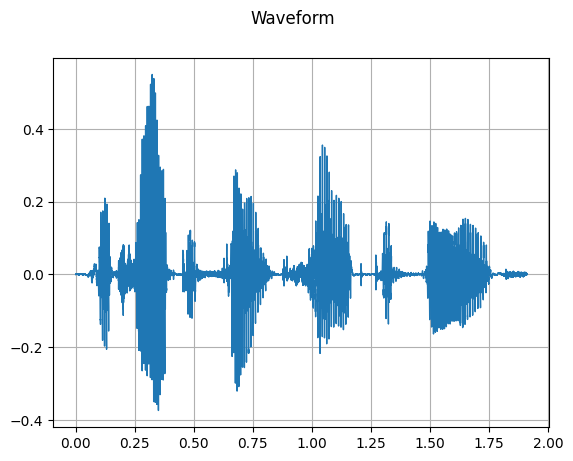

In [ ]:
plot_waveform(ds[0][0], ds[0][1])

In [ ]:
#| export
class LibriTTSDataModule(LightningDataModule):
    def __init__(self,
        target_dir="/data/en/libriTTS", # where data will be saved / retrieved
        dataset_parts=["dev-clean", "test-clean"], # either full libritts or subset
        output_dir="/home/syl20/slg/nimrod/recipes/libritts/data", # where to save manifest
        num_jobs=0 # num_jobs depending on number of cpus available
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)

    def prepare_data(self,) -> None:
        # takes a while to download from openslr mirror (~15 min each for test/dev-clean)
        download_libritts(target_dir=self.hparams.target_dir, dataset_parts=self.hparams.dataset_parts)

    def setup(self, stage = None):
        self.libri = prepare_libritts(corpus_dir=Path(self.hparams.target_dir) / "LibriTTS", dataset_parts=self.hparams.dataset_parts, output_dir=self.hparams.output_dir, num_jobs=self.hparams.num_jobs)
        if stage == 'fit' or stage == None:
            self.cuts_train = CutSet.from_manifests(**self.libri["dev-clean"])
            self.cuts_test = CutSet.from_manifests(**self.libri["test-clean"])
            self.tokenizer = TokenCollater(self.cuts_train)
            self.tokenizer(self.cuts_test.subset(first=2))
            # self.tokenizer.inverse(*self.tokenizer(self.cuts_test.subset(first=2)))
        if stage == "test":
            self.cuts_test = CutSet.from_manifests(**self.libri["test-clean"])
            self.tokenizer = TokenCollater(self.cuts_test)
            self.tokenizer(self.cuts_test.subset(first=2))
            # self.tokenizer.inverse(*self.tokenizer(self.cuts_test.subset(first=2)))

    def train_dataloader(self):
        train_sampler = BucketingSampler(self.cuts_train, max_duration=300, shuffle=True) #, bucket_method="equal_duration")
        return DataLoader(TTSDataset(self.tokenizer, sampling_rate=24000), sampler=train_sampler, batch_size=None, num_workers=self.hparams.num_jobs)

    def test_dataloader(self):
        test_sampler = BucketingSampler(self.cuts_test, max_duration=400, shuffle=False) #, bucket_method="equal_duration")
        return DataLoader(TTSDataset(self.tokenizer, sampling_rate=24000), sampler=test_sampler, batch_size=None, num_workers=self.hparams.num_jobs)

    @property
    def model_kwargs(self):
        return {
            "odim": len(self.tokenizer.idx2token),
        }

### Usage

In [ ]:
# num_jobs=0 turns parallel computing off within jupyter notebook. Else it fails.
dm = LibriTTSDataModule(
    target_dir="../data/en", 
    dataset_parts="test-clean",
    output_dir="../data/en/LibriTTS/test-clean",
    num_jobs=1
)

In [ ]:
# skip download and use local data folder
# dm.prepare_data()

In [ ]:
# libri = prepare_libritts("../data/en/LibriTTS", dataset_parts="test-clean")

In [ ]:
dm.setup(stage='test')

Preparing LibriTTS parts: 100%|██████████| 1/1 [00:00<00:00, 2957.90it/s]


In [ ]:
test_dl = dm.test_dataloader()
batch = next(iter(test_dl))
print(batch.keys())

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608632396/work/aten/src/ATen/ParallelNative.cpp:228.)
  torch.set_num_threads(1)


torch.Size([34, 1156, 80])
tensor([1156, 1155, 1154, 1153, 1152, 1151, 1148, 1148, 1148, 1148, 1146, 1145,
        1145, 1145, 1144, 1144, 1143, 1143, 1143, 1142, 1141, 1141, 1141, 1140,
        1140, 1140, 1139, 1138, 1138, 1138, 1137, 1137, 1137, 1135])
tensor([ 2, 24, 57,  4, 63, 51, 48,  4, 56, 58, 47, 48, 61, 57,  4, 46, 58, 56,
        56, 64, 57, 52, 63, 68,  4, 63, 51, 48, 61, 48,  4, 52, 62,  4, 44, 55,
        62, 58,  4, 44,  4, 56, 58, 61, 48,  4, 49, 61, 48, 60, 64, 48, 57, 63,
         4, 44, 63, 63, 48, 57, 47, 44, 57, 46, 48,  4, 44, 63,  4, 55, 44, 61,
        50, 48,  4, 50, 44, 63, 51, 48, 61, 52, 57, 50, 62,  4, 58, 49,  4, 59,
        48, 58, 59, 55, 48,  4, 63, 58,  4, 66, 51, 58, 56,  4, 58, 57, 48,  7,
        62,  4, 48, 65, 48, 61, 68, 47, 44, 68,  4, 55, 52, 49, 48,  4, 52, 62,
         4, 64, 57, 54, 57, 58, 66, 57, 14,  4, 52, 57,  4, 62, 64, 46, 51,  4,
        59, 55, 44, 46, 48, 62,  4, 44, 62,  4, 46, 51, 64, 61, 46, 51, 48, 62,
        10,  4, 63, 51, 

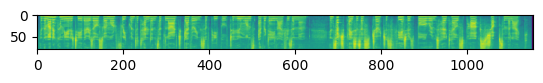

In [ ]:
print(batch['feats_pad'].shape)
plt.imshow(batch['feats_pad'][3].transpose(0,1))
print(batch['feats_lens'])
print(batch['tokens_pad'][3], batch['tokens_lens'][3])

In [ ]:
original_sentences = dm.tokenizer.inverse(batch['tokens_pad'], batch['tokens_lens'])
print(original_sentences)

['He was quiet, and I might almost say silent, during the whole evening; but I could see from the testimony of his altered countenance how strong is the passion for life that dwells in the human breast.', 'I don\'t need Marie to dress me this season, so she keeps house for me, and my little Galway girl has gone home for a visit. I should never have asked you if Molly had been here, for I remember you don\'t like English cookery."', 'She made all this known to her husband; and it was finally settled between the three that they should not move in the matter for the present, but wait till the will of Heaven had declared itself respecting the little patient.', "In the modern community there is also a more frequent attendance at large gatherings of people to whom one's everyday life is unknown; in such places as churches, theaters, ballrooms, hotels, parks, shops, and the like.", 'Do you know, Alexander,"--Mainhall looked with perplexity up into the top of the hansom and rubbed his pink che

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()